In [1]:
# Stanford University, Winter 2021, STEMREM 205 Final Project
# Title: Analyzing the Reprogramming of Rejuvenation
# This notebook pre-processes the data for DMR analysis in the metilene software
# The notebook also analyzes the output from the metilene software package
# Command line codes that were used for metilene can be found in the GitHub repository
# by: Sani Eskinazi, Joseph Wakim, Mahdi Moqri, PhD

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

In [3]:
rep='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/GSE142439/matrix//GSE142439_series_matrix.txt.gz'
epic_man='https://webdata.illumina.com/downloads/productfiles/methylationEPIC/infinium-methylationepic-v-1-0-b5-manifest-file-csv.zip'

In [4]:
# Download Methylation Data
df=pd.read_csv(rep,sep='\t',skiprows=71,index_col=0) # methylation data starts from line 71
df=df.drop('!series_matrix_table_end')


In [5]:
# Combine methylation data with treatment, age, and cell type
meta=pd.read_csv(rep,sep='\t',skiprows=40,index_col=0,nrows=3) # meta data starts from line 40
meta.columns=df.columns
meta.index=['age','cell','treatment']
meta=meta.T
meta['age']=meta.age.str.strip('age: ')
meta['cell']=meta.cell.str.strip('cell type: ')
meta['treatment']=meta.treatment.str.strip('treatmentstatus: ')
meta['t']=meta.treatment.apply(lambda x: 1 if x=='Normal' else 0)
meta['cell']=meta.cell.apply(lambda x: 'skin' if x=='skin fibroblasts' else 'vein')
meta.T

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,GSM4227395,GSM4227396,GSM4227397,GSM4227398,GSM4227399,GSM4227400
age,61,61,61,61,69,69,67,67,48,48,47,47,49,49,49,49
cell,skin,skin,skin,skin,skin,skin,skin,skin,vein,vein,vein,vein,vein,vein,vein,vein
treatment,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated
t,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [6]:
# Generate Dataframes for DMR Analysis
column_dict = {}
for i in range (len(df.columns)):
    column_dict[df.columns[i]] = meta.T.iloc[2,i]
df_DMR = df.rename(columns=column_dict) #Dataframe for DMR analysis on all samples
df_DMR.sort_index(axis=1, inplace=True)
df_DMR_skin = df_DMR.iloc[:,:8] #Dataframe for DMR analysis on skin fibroblast

In [7]:
# Adjust column names to match metilene input format
# groupA for metilene = Normal; groupB for metilene = Treated
df_DMR_skin = df.iloc[:,:8]
df_DMR_skin.columns = ['Normal', 'Treated','Normal', 'Treated','Normal', 'Treated','Normal', 'Treated' ]
df_DMR_skin = df_DMR_skin.rename(columns=column_dict)
df_DMR_skin.sort_index(axis=1, inplace=True)
df_DMR_skin


,Normal,Normal,Normal,Normal,Treated,Treated,Treated,Treated
ID_REF,,,,,,,,
cg00000029,0.192582,0.084506,0.202294,0.185225,0.229640,0.102028,0.170894,0.229188
cg00000103,0.050515,0.329022,0.341425,0.257052,0.040341,0.189790,0.341412,0.240811
cg00000109,0.617563,0.612092,0.814250,0.579529,0.642911,0.488234,0.836173,0.590639
cg00000155,0.896258,0.882052,0.890299,0.917016,0.914563,0.908893,0.884905,0.885932
cg00000158,0.912854,0.905442,0.886896,0.916827,0.917489,0.906985,0.823321,0.929487
...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.026698,0.026375,0.026023,0.029316,0.019795,0.025582,0.025811,0.022566
ch.X.97133160R,0.040811,0.074792,0.050386,0.049384,0.063230,0.049254,0.078883,0.053192
ch.X.97651759F,0.027727,0.032493,0.027609,0.018154,0.022679,0.033779,0.028412,0.021472


In [8]:
# Generate Pandas Dataframe on Illumina Probes and Chromosome Locations
epic=pd.read_csv(epic_man,skiprows=7,index_col=0) # data starts from line 7


/Users/sanieskinazi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,4,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
# Generate dataframe of the chromosome and location of all Illumina probes
met_loc = epic[['CHR_hg38', 'Start_hg38']]



In [10]:
# Prepare df_DMR for Metilene Input by adding columns that show
# chromosome number and position on chromosome
df_DMR.insert(loc=0, column='CHR', value='NaN')
df_DMR.insert(loc=1, column='Pos', value='NaN')

# df_DMR.loc[df_DMR.IDs(met_loc.CHR_hg38), 'CHR'] = met_loc.CHR_hg38
df_DMR.head(2)

,CHR,Pos,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Treated,Treated,Treated,Treated,Treated,Treated,Treated,Treated
ID_REF,,,,,,,,,,,,,,,,,,
cg00000029,NaN,NaN,0.192582,0.084506,0.202294,0.185225,0.192410,0.806773,0.358765,0.446669,0.229640,0.102028,0.170894,0.229188,0.152512,0.865000,0.366739,0.433033
cg00000103,NaN,NaN,0.050515,0.329022,0.341425,0.257052,0.068477,0.399574,0.142422,0.451088,0.040341,0.189790,0.341412,0.240811,0.046939,0.466977,0.062342,0.469305


In [11]:
# Generate a dictionary where the key is the illumina probe ID
# and the value is a tuple of chrosome number and chromosome location
loc_set = set(met_loc.index)
df_dict = {}
for ID in df_DMR.index:
    if ID in loc_set:
        chr_num = str(met_loc.loc[ID, 'CHR_hg38'])
        if chr_num != 'nan':
            df_dict[ID] = (chr_num[3:], met_loc.loc[ID, 'Start_hg38'])


In [12]:
# Assign chromosome numbers and positions to df
# Remove all 'Nan'
# This will make your df ready for inputting into metilene
chr_pos_df = pd.DataFrame.from_dict(df_dict, orient='index')
df_DMR['CHR'] = chr_pos_df[0]
df_DMR['Pos'] = chr_pos_df[1]
df_DMR = df_DMR.dropna()

df_DMR.head(2)

,CHR,Pos,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Treated,Treated,Treated,Treated,Treated,Treated,Treated,Treated
ID_REF,,,,,,,,,,,,,,,,,,
cg00000029,16,53434199.0,0.192582,0.084506,0.202294,0.185225,0.192410,0.806773,0.358765,0.446669,0.229640,0.102028,0.170894,0.229188,0.152512,0.865000,0.366739,0.433033
cg00000103,4,72604468.0,0.050515,0.329022,0.341425,0.257052,0.068477,0.399574,0.142422,0.451088,0.040341,0.189790,0.341412,0.240811,0.046939,0.466977,0.062342,0.469305


In [13]:
# Prepare df_DMR_skin for Metilene Input by adding columns that show
# chromosome number and position on chromosome
df_DMR_skin.insert(loc=0, column='CHR', value='NaN')
df_DMR_skin.insert(loc=1, column='Pos', value='NaN')
df_DMR_skin['CHR'] = chr_pos_df[0]
df_DMR_skin['Pos'] = chr_pos_df[1]
df_DMR_skin = df_DMR_skin.dropna()



In [14]:
# For All samples metilene analysis:
# Sort and save your metilene input as a txt file 
df_DMR = df_DMR.sort_values(by=['CHR', 'Pos'])
df_DMR.to_csv('DMR_metiline_in.txt', sep ='\t', index=False) 

In [15]:
# For Skin Fibroblast metilene analysis:
# Sort and save your metilene input as a txt file 
df_DMR_skin = df_DMR_skin.sort_values(by=['CHR', 'Pos'])
df_DMR_skin.to_csv('DMR_skin_metiline_in.txt', sep ='\t', index=False) 

The Cells Below will be Analyzing the outputs of the metilene software. There are 4 outputs: 
1) All Samples, min CpG = 10
2) Only Skin Samples, min CpG = 10
3) All Samples, min CpG = 5
4) Only skin fibroblasts, min CpG = 5

In [16]:
# Metilene All Samples Output min CpG = 10
metilene_df =pd.read_csv('metiline4.output', sep ='\t', header=None)
metilene_df.columns = ['chr', 'start', 'stop', 'q-val', 'Mean diff', 'No_CpGs', 'p(MWU)', 'p(2D_KS)', 'Mean_Normal', 'Mean_Treated']
print("There are {} DMRs in all samples with min CpG=10". format(len(metilene_df.index)))

There are 193 DMRs in all samples with min CpG=10


In [17]:
#Metilene Skin Output min CpG = 10
metilene_skin = pd.read_csv('metilene_skin.output', sep ='\t', header=None)
metilene_skin.columns = ['chr', 'start', 'stop', 'q-val', 'Mean diff', 'No_CpGs', 'p(MWU)', 'p(2D_KS)', 'Mean_Normal', 'Mean_Treated']
print("There are {} DMRs in skin fibroblasts with min CpG=10". format(len(metilene_skin.index)))

There are 355 DMRs in skin fibroblasts with min CpG=10


In [18]:
# Find the DMRs That Are Statistically Significant, in Skin, CpG = 10
skin_significant = metilene_skin[metilene_skin['p(MWU)'] < 0.05]
skin_significant

,chr,start,stop,q-val,Mean diff,No_CpGs,p(MWU),p(2D_KS),Mean_Normal,Mean_Treated
208,11,1998336,1998505,1,-0.021233,10,0.04854,0.28341,0.46722,0.48845


In [19]:
#Metilene All Output for Min CpG = 5
metilene_all_5 =pd.read_csv('metilene_all_5.output', sep ='\t', header=None)
metilene_all_5.columns = ['chr', 'start', 'stop', 'q-val', 'Mean diff', 'No_CpGs', 'p(MWU)', 'p(2D_KS)', 'Mean_Normal', 'Mean_Treated']
metilene_all_5.sort_values(by=['p(MWU)'], ascending = True)
all_significant_5 = metilene_all_5[metilene_all_5['p(MWU)'] < 0.05]
all_significant_5 = all_significant_5.drop(['q-val', 'p(2D_KS)'], axis=1)
all_significant_5.sort_values(by=['p(MWU)'], ascending = True).head(5)
print("There are {} DMRs in all samples with min CpG=5". format(len(metilene_all_5.index)))

There are 3076 DMRs in all samples with min CpG=5


In [20]:
#Metilene Skin Output for Min CpG = 5
metilene_skin_5 =pd.read_csv('metilene_skin_5.output', sep ='\t', header=None)
metilene_skin_5.columns = ['chr', 'start', 'stop', 'q-val', 'Mean diff', 'No_CpGs', 'p(MWU)', 'p(2D_KS)', 'Mean_Normal', 'Mean_Treated']
metilene_skin_5.sort_values(by=['p(MWU)'], ascending = True)
skin_significant_5 = metilene_skin_5[metilene_skin_5['p(MWU)'] < 0.05]
skin_significant_5 = skin_significant_5.drop(['q-val', 'p(2D_KS)'], axis=1)
skin_significant_5.sort_values(by=['p(MWU)'], ascending = True).head(5)
print("There are {} DMRs in skin fibroblasts with min CpG=5". format(len(metilene_skin_5.index)))

There are 4771 DMRs in skin fibroblasts with min CpG=5


Text(0.5, 1.0, 'Histogram of DMRs in Skin Fibroblasts')

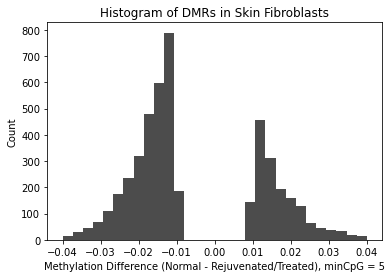

In [21]:
# Histogram, Methylation Difference, Skin, CpG = 5
plt.hist(metilene_skin_5['Mean diff'], bins = 30, alpha=0.7, color='black', range = (-0.04,0.04))
plt.xlabel('Methylation Difference (Normal - Rejuvenated/Treated), minCpG = 5')
plt.ylabel('Count')
plt.title('Histogram of DMRs in Skin Fibroblasts')

In [22]:
# Hypo vs Hypermethylation of DMRs
hypo_num = len(metilene_skin_5[(metilene_skin_5['Mean diff'] > 0)].index)
hyper_num = len(metilene_skin_5[(metilene_skin_5['Mean diff'] < 0)].index)
print("{}% increased in methylation, {}% decreased in methylation".
      format(hyper_num/len(metilene_skin_5['Mean diff']), hypo_num/len(metilene_skin_5['Mean diff'])))

0.6422133724586041% increased in methylation, 0.35778662754139595% decreased in methylation


median is:  416


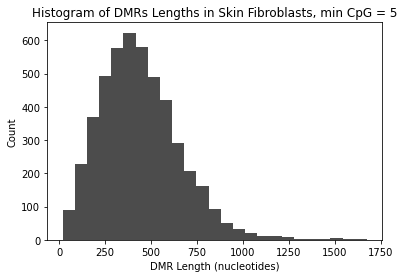

In [23]:
#Histogram, DMR Lenghts, Skin, CpG = 5
plt.hist((metilene_skin_5['stop'] - metilene_skin_5['start']), bins = 25, alpha=0.7, color='black', density = False)
plt.xlabel('DMR Length (nucleotides)')
plt.ylabel('Count')
plt.title('Histogram of DMRs Lengths in Skin Fibroblasts, min CpG = 5')

print("median is: ", statistics.median((metilene_skin_5['stop'] - metilene_skin_5['start'])))
basepairs_skin5 = list((metilene_skin_5['stop'] - metilene_skin_5['start']))

In [24]:
#Find Percentage of Genome Covered by DMRs
total_nuc = sum(basepairs_skin5)
print("Percentage of Genome that our DMRs (min 5 CpGs) cover is {}%". format (100*total_nuc/(3*(10**9))))

Percentage of Genome that our DMRs (min 5 CpGs) cover is 0.06977376666666667%


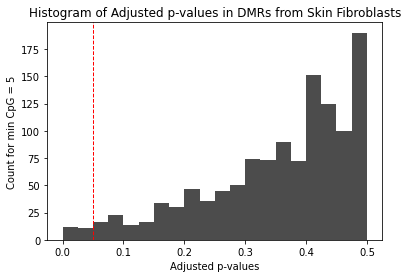

In [25]:
# P-value Histograms of Skin, CpG=5
plt.hist(metilene_skin_5['p(MWU)'], bins = 20, alpha=0.7, color='black', range = (0, 0.5))
plt.xlabel('Adjusted p-values')
plt.ylabel('Count for min CpG = 5')
plt.title('Histogram of Adjusted p-values in DMRs from Skin Fibroblasts')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=1)

In [26]:
# Find number of statistically significant DMRs
print('There are {} statistically significant DMRs'.
      format(len(metilene_skin_5[(metilene_skin_5['p(MWU)'] < 0.05)].index)))

There are 23 statistically significant DMRs


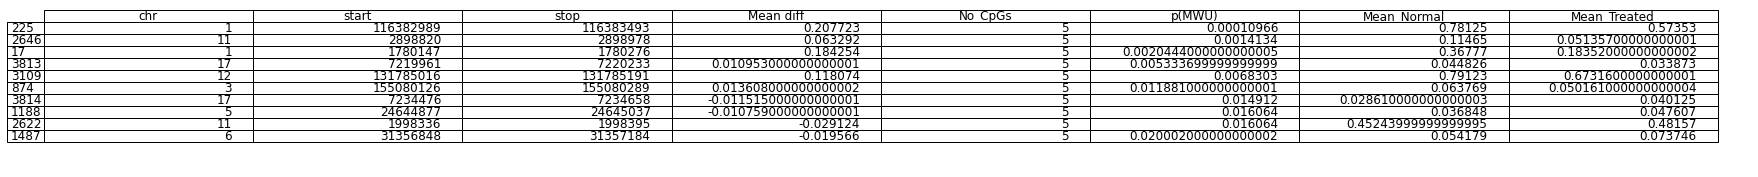

In [27]:
#Show Table of 10 most significant DMRs in Skin Fibroblasts, CpG=5
from pandas.plotting import table
# set fig size
fig, ax = plt.subplots(figsize=(30, 3)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, skin_significant_5.sort_values(by=['p(MWU)'], ascending = True).head(10), loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(12) 
# save the result
plt.savefig('table.png')